In [ ]:
!pip install accelerate -U

In [1]:
import transformers
import torch, torchtext
import torch.nn.functional as F
import torch.nn as nn
import copy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from transformers import BertTokenizer, BertModel, AutoModel, AutoProcessor
from tqdm import tqdm

import os
import sys
import math
import gc
import datetime
import datetime as dt
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
EMBEDDING_DIM = 768
image_size = 224
MODEL_NUM_LABELS = 2
TEXT_MODEL_CARD = 'bert-base-uncased'

LABEL_2_ID = {
    'normal': 0,
    'Lung': 1
}
ID_2_LABEL = {
    0: 'normal',
    1: 'Lung'
}

cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/LungsImgDatasetInd/images_normalized"
dir_list = os.listdir(path)

In [4]:
df2 = pd.read_csv('/content/drive/MyDrive/LungsImgDatasetInd/indiana_projections.csv')
df1 = pd.read_csv('/content/drive/MyDrive/LungsImgDatasetInd/indiana_reports.csv')
df2 = df2.loc[df2['projection'].isin(['Frontal'])]
df2 = df2.loc[df2['filename'].isin(dir_list)]
df1.loc[df1['Problems'].str.contains('Lung'),'Problems']='Lung'
df1_l = df1.loc[df1['Problems'].isin(['Lung'])]

df1_n = df1.loc[df1['Problems'].isin(['normal'])]
print(len(df1_l), len(df1_n))
df1_n = df1_n.iloc[:len(df1_l)-len(df1_n)]
df1 = pd.concat([df1_l, df1_n], axis=0).sample(frac=1).reset_index(drop=True)
df1 = df1[:]
print(len(df1))


images_captions_df = pd.DataFrame({'image': [], 'caption': [],'number_of_words':[],'problem':[]})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]

    if not index.empty:
        index = index.index[0]
        caption = df1.loc[index]['findings']
        problem = df1.loc[index]['Problems']
        number_of_words = len(str(caption).split())

        if type(caption) == float:
                continue
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'image': image, 'caption': caption ,'number_of_words':number_of_words,'problem':problem}])], ignore_index=True)

images_captions_df["number_of_words"] =  images_captions_df["caption"].apply(lambda text: len(str(text).split()))
images_captions_df['number_of_words'] = images_captions_df['number_of_words'].astype(int)

print(images_captions_df.head())

558 1379
1116
                       image  \
0     1_IM-0001-4001.dcm.png   
1  5_IM-2117-1003002.dcm.png   
2    11_IM-0067-1001.dcm.png   
3    12_IM-0133-1001.dcm.png   
4    14_IM-0256-1001.dcm.png   

                                             caption  number_of_words problem  
0  The cardiac silhouette and mediastinum size ar...               34  normal  
1  The cardiomediastinal silhouette and pulmonary...               42    Lung  
2  Cardiomediastinal silhouette and pulmonary vas...               21  normal  
3  Lungs are clear bilaterally. Cardiac and media...               23  normal  
4  Heart size within normal limits, stable medias...               37    Lung  


'from sklearn.model_selection import train_test_split\n\nimage_folder = path\nimage_filenames = images_captions_df.image.values\n\n# image_filenames = image_filenames[0:100]\n\ntrain_captions,test_captions =train_test_split(images_captions_df, test_size = 0.2)\n#test_captions, val_captions =train_test_split(test_val_captions, test_size = 0.4)\n\nprint(train_captions.head())\nprint(len(train_captions),len(test_captions))#,len(val_captions)'

In [5]:
images_captions_df.head()

,image,caption,number_of_words,problem
0,1_IM-0001-4001.dcm.png,The cardiac silhouette and mediastinum size ar...,34,normal
1,5_IM-2117-1003002.dcm.png,The cardiomediastinal silhouette and pulmonary...,42,Lung
2,11_IM-0067-1001.dcm.png,Cardiomediastinal silhouette and pulmonary vas...,21,normal
3,12_IM-0133-1001.dcm.png,Lungs are clear bilaterally. Cardiac and media...,23,normal
4,14_IM-0256-1001.dcm.png,"Heart size within normal limits, stable medias...",37,Lung


In [6]:
images_captions_df['image'] = path + '/' + images_captions_df['image']

In [8]:
#import requests
max_length=512
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, images_captions_df, image_processor):
        self.images = images_captions_df['image'].values
        self.captions = images_captions_df['problem'].values
        self.image_processor = image_processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = str(self.images[idx])
        image = Image.open(image_path)
        image = Image.open(image_path).convert("RGB")
        image_features = self.image_processor(image, return_tensors="pt").pixel_values
        labels = LABEL_2_ID[self.captions[idx]]

        return {'pixel_values': image_features.squeeze(0), 'labels': labels,'decoder_start_token_id':2}


In [10]:
from sklearn.model_selection import train_test_split
train_df,test_df =train_test_split(images_captions_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_df

,image,caption,number_of_words,problem
128,/content/drive/MyDrive/LungsImgDatasetInd/imag...,The cardiomediastinal silhouette is normal in ...,27,Lung
104,/content/drive/MyDrive/LungsImgDatasetInd/imag...,The cardiomediastinal silhouette and vasculatu...,29,normal
78,/content/drive/MyDrive/LungsImgDatasetInd/imag...,Heart size and mediastinal contours appear wit...,31,normal
36,/content/drive/MyDrive/LungsImgDatasetInd/imag...,"No pneumothorax, pleural effusion or airspace ...",20,normal
93,/content/drive/MyDrive/LungsImgDatasetInd/imag...,Both lungs are clear and expanded. Heart and m...,10,normal
...,...,...,...,...
71,/content/drive/MyDrive/LungsImgDatasetInd/imag...,Lungs are clear bilaterally. There is no focal...,22,normal
106,/content/drive/MyDrive/LungsImgDatasetInd/imag...,The cardiomediastinal silhouette is within nor...,30,normal
14,/content/drive/MyDrive/LungsImgDatasetInd/imag...,The lungs and pleural spaces show no acute abn...,17,normal
92,/content/drive/MyDrive/LungsImgDatasetInd/imag...,The heart is normal in size. The mediastinum i...,14,normal


In [11]:
from transformers import BertConfig, ViTModel, ViTConfig, VisionEncoderDecoderConfig, VisionEncoderDecoderModel

image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [13]:
datsets_train = CaptionDataset(train_df,image_processor)
dataset_test = CaptionDataset(test_df,image_processor)
#dataset_val = CaptionDataset(val_df,image_processor),len(val_captions)

In [ ]:
datsets_train.__getitem__(0)

{'pixel_values': tensor([[[-0.0118, -0.0196, -0.0118,  ..., -0.2392, -0.4196, -0.4902],
          [ 0.0902,  0.0510,  0.0353,  ..., -0.2549, -0.3882, -0.4667],
          [ 0.1765,  0.1922,  0.1686,  ..., -0.2784, -0.3647, -0.4353],
          ...,
          [-0.4745, -0.4824, -0.4980,  ..., -0.1451, -0.0510,  0.0275],
          [-0.4667, -0.4824, -0.5216,  ..., -0.1294, -0.0510,  0.0196],
          [-0.4745, -0.4902, -0.5137,  ..., -0.0980, -0.0353,  0.0431]],
 
         [[-0.0118, -0.0196, -0.0118,  ..., -0.2392, -0.4196, -0.4902],
          [ 0.0902,  0.0510,  0.0353,  ..., -0.2549, -0.3882, -0.4667],
          [ 0.1765,  0.1922,  0.1686,  ..., -0.2784, -0.3647, -0.4353],
          ...,
          [-0.4745, -0.4824, -0.4980,  ..., -0.1451, -0.0510,  0.0275],
          [-0.4667, -0.4824, -0.5216,  ..., -0.1294, -0.0510,  0.0196],
          [-0.4745, -0.4902, -0.5137,  ..., -0.0980, -0.0353,  0.0431]],
 
         [[-0.0118, -0.0196, -0.0118,  ..., -0.2392, -0.4196, -0.4902],
          [ 

In [14]:
class Trainer():
    def __init__(self,
                 #dataset,
                net,
                loss_f, learning_rate=1e-3,
                epoch_amount=10, batch_size=12,
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10,
                optim=torch.optim.Adam,
                scheduler=None, permutate=True):

        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.start_model = net
        self.best_model = net
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []

    def predict(self, X):
        return self.best_model(X)

    def fit(self, train, val):
        Net = self.start_model

        device = torch.device(self.device)

        Net.to(self.device)

        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        best_val_loss = float('inf')
        best_ep = 0
        for epoch in range(self.epoch_amount):
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0
            correct = 0

            for batch in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()
                batch_X = batch['pixel_values'].unsqueeze(0)
                target = batch['labels']
                target = torch.tensor(target).unsqueeze(0)
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)
                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()
                correct += torch.eq(torch.argmax(predicted_values, dim=-1), target).view(-1).sum()
                mean_loss += float(loss)
                batch_n += 1
            print('correct.item()',correct.item(), 'batch_n', batch_n)
            training_accuracy = correct.item() / batch_n
            self.train_accuracy.append(training_accuracy)
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, Accuracy_train: {training_accuracy}, {dt.datetime.now() - start} сек')
            Net.eval()
            mean_loss = 0
            batch_n = 0
            num_correct = 0
            num_examples = 0
            tot_pred, tot_targ, tot_logits = torch.LongTensor(), torch.LongTensor(), torch.LongTensor()
            with torch.no_grad():
                for batch in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                    batch_X = batch['pixel_values'].unsqueeze(0)
                    target = batch['labels']
                    target = torch.tensor(target).unsqueeze(0)
                    batch_X = batch_X.to(self.device)
                    target = target.to(self.device)
                    predicted_values = Net(batch_X)
                    loss = self.loss_f(predicted_values, target)
                    mean_loss += float(loss)
                    batch_n += 1
                    scores = predicted_values[:, :2]
                    predicted_lab = torch.argmax(scores, dim=-1)
                    tot_pred = torch.cat((tot_pred, predicted_lab.detach().cpu()))
                    tot_targ = torch.cat((tot_targ, target.detach().cpu()))
                    tot_logits = torch.cat((tot_logits, torch.nn.functional.softmax(scores, dim=-1)[:, 1].detach().cpu()))
                    correct = torch.eq(predicted_lab, target).view(-1)
                    num_correct += torch.sum(correct).item()
                    num_examples += correct.shape[0]
            accuracy = num_correct/num_examples
            self.val_accuracy.append(accuracy)
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}, Accuracy_val: {accuracy}')
            print(self.val_loss, self.val_accuracy, self.train_loss, self.train_accuracy)
            if mean_loss < best_val_loss:
                self.best_model = Net
                print('save model')
                torch.save(self.best_model, '/content/drive/MyDrive/models/'+'Img_model_norm_'+datetime.datetime.now().strftime("%Y_%m_%d")+str(accuracy))
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()
        return self.val_loss, self.val_accuracy, self.train_loss, self.train_accuracy

In [15]:
VIT = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
class ViTForImageClassification(nn.Module):
    def __init__(self, head, num_labels=MODEL_NUM_LABELS):
        super(ViTForImageClassification, self).__init__()
        self.vit = VIT
        self.dropout = nn.Dropout(0.1)
        self.head = head
    def forward(self, pixel_values):
        pixel_values_0 = torch.tensor(pixel_values).clone().detach()
        outputs = self.vit(pixel_values=pixel_values_0)
        last_hidden_states = outputs.pooler_output
        output = self.dropout(last_hidden_states)
        return self.head(output)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [16]:
multa_d_ffn=2048
hidden_state_index=8
multa_nblocks=4
head_hidden_dimension=224
img_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, MODEL_NUM_LABELS)
    ).to(device)
model_img = ViTForImageClassification(img_head)

In [ ]:
'''img_head = nn.Sequential(
        nn.Dropout(0.1),
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
model_img = ViTForImageClassification(img_head)'''

In [ ]:
#non-segmented images max Accuracy_val: 0.7743589743589744 on 13 epoch
params = {
    'net': model_img,
    'epoch_amount': 50,
    'learning_rate': 5e-5,
    'early_stopping': 25,
    'loss_f':  nn.CrossEntropyLoss(),
    'optim':  torch.optim.Adam
}

clf_load = Trainer(**params)
clf_load.fit(datsets_train, dataset_test)

Эпоха: 0 

<ipython-input-14-1b806883825a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values_0 = torch.tensor(pixel_values).clone().detach()


correct.item() 415 batch_n 777
Loss_train: 0.7122418671712145, Accuracy_train: 0.5341055341055341, 0:47:02.710084 сек
100 195
Loss_val: 0.7082975139984717, Accuracy_val: 0.5128205128205128
[0.7082975139984717] [0.5128205128205128] [0.7122418671712145] [0.5341055341055341]
save model

Эпоха: 1 correct.item() 467 batch_n 777
Loss_train: 0.6678447330591091, Accuracy_train: 0.601029601029601, 0:39:46.826125 сек
136 195
Loss_val: 0.5948200409993147, Accuracy_val: 0.6974358974358974
[0.7082975139984717, 0.5948200409993147] [0.5128205128205128, 0.6974358974358974] [0.7122418671712145, 0.6678447330591091] [0.5341055341055341, 0.601029601029601]
save model

Эпоха: 2 correct.item() 559 batch_n 777
Loss_train: 0.5594304530093857, Accuracy_train: 0.7194337194337195, 0:39:08.244762 сек
115 195
Loss_val: 0.7392919100247897, Accuracy_val: 0.5897435897435898
[0.7082975139984717, 0.5948200409993147, 0.7392919100247897] [0.5128205128205128, 0.6974358974358974, 0.5897435897435898] [0.7122418671712145, 0.

KeyboardInterrupt: 

In [ ]:
#non-segmented images dropout 0.5 max Accuracy_val: 0.7692307692307693 4 epoch
params = {
    'net': model_img,
    'epoch_amount': 50,
    'learning_rate': 5e-5,
    'early_stopping': 25,
    'loss_f':  nn.CrossEntropyLoss(),
    'optim':  torch.optim.Adam
}

clf = Trainer(**params)
clf.fit(datsets_train, dataset_test)

Эпоха: 0 

<ipython-input-35-1b806883825a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values_0 = torch.tensor(pixel_values).clone().detach()


correct.item() 417 batch_n 777
Loss_train: 0.708401144145385, Accuracy_train: 0.5366795366795367, 0:34:04.613704 сек
102 195
Loss_val: 0.6872923682897519, Accuracy_val: 0.5230769230769231
[0.6872923682897519] [0.5230769230769231] [0.708401144145385] [0.5366795366795367]

Эпоха: 1 correct.item() 488 batch_n 777
Loss_train: 0.6544024763075081, Accuracy_train: 0.6280566280566281, 0:34:13.683155 сек
121 195
Loss_val: 0.6439250058852709, Accuracy_val: 0.6205128205128205
[0.6872923682897519, 0.6439250058852709] [0.5230769230769231, 0.6205128205128205] [0.708401144145385, 0.6544024763075081] [0.5366795366795367, 0.6280566280566281]

Эпоха: 2 correct.item() 528 batch_n 777
Loss_train: 0.6025327531527368, Accuracy_train: 0.6795366795366795, 0:34:28.202961 сек
127 195
Loss_val: 0.6126559576927088, Accuracy_val: 0.6512820512820513
[0.6872923682897519, 0.6439250058852709, 0.6126559576927088] [0.5230769230769231, 0.6205128205128205, 0.6512820512820513] [0.708401144145385, 0.6544024763075081, 0.6025

In [ ]:
#non-segmented images dout 0.1
params = {
    'net': model_img,
    'epoch_amount': 100,
    'learning_rate': 8e-5,
    'early_stopping': 25,
    'loss_f':  nn.CrossEntropyLoss(),
    'optim':  torch.optim.Adam
}

clf = Trainer(**params)
clf.fit(datsets_train, dataset_val)

Эпоха: 0 

<ipython-input-22-fe1bd11d8e59>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values_0 = torch.tensor(pixel_values).clone().detach()


correct.item() 64 batch_n 123
Loss_train: 0.7745431788810869, Accuracy_train: 0.5203252032520326, 0:05:54.270091 сек
predicted_values tensor([[-0.3252, -0.0463]]) target tensor([1])
predicted_values tensor([[-0.3640, -0.0369]]) target tensor([0])
predicted_values tensor([[-0.3664, -0.0268]]) target tensor([1])
predicted_values tensor([[-0.3735, -0.0473]]) target tensor([0])
predicted_values tensor([[-0.3408, -0.0792]]) target tensor([1])
predicted_values tensor([[-0.3441, -0.0823]]) target tensor([0])
predicted_values tensor([[-0.3187, -0.0531]]) target tensor([0])
predicted_values tensor([[-0.3447, -0.0864]]) target tensor([0])
predicted_values tensor([[-0.3689, -0.0869]]) target tensor([0])
predicted_values tensor([[-0.3432, -0.0576]]) target tensor([1])
predicted_values tensor([[-0.3427, -0.0574]]) target tensor([1])
predicted_values tensor([[-0.3450, -0.0382]]) target tensor([0])
predicted_values tensor([[-0.3418, -0.0957]]) target tensor([1])
predicted_values tensor([[-0.3255, -0.

KeyboardInterrupt: 

In [ ]:
#segmented images
params = {
    'net': model_img,
    'epoch_amount': 100,
    'learning_rate': 5e-5,
    'early_stopping': 25,
    'loss_f':  nn.CrossEntropyLoss(),
    'optim':  torch.optim.Adam
}

clf = Trainer(**params)
clf.fit(datsets_train, dataset_val)

Эпоха: 0 correct.item() 70 batch_n 119
Loss_train: 0.695454605862874, Accuracy_train: 0.5882352941176471, 0:05:17.369275 сек
predicted_values tensor([[-0.3515,  0.3989]]) target tensor([0])
predicted_values tensor([[-0.3738,  0.4046]]) target tensor([1])
predicted_values tensor([[-0.3673,  0.4050]]) target tensor([1])
predicted_values tensor([[-0.3698,  0.4126]]) target tensor([0])
predicted_values tensor([[-0.3638,  0.4230]]) target tensor([1])
predicted_values tensor([[-0.3696,  0.4159]]) target tensor([0])
predicted_values tensor([[-0.3770,  0.4126]]) target tensor([0])
predicted_values tensor([[-0.3691,  0.4087]]) target tensor([0])
predicted_values tensor([[-0.3682,  0.3985]]) target tensor([1])
predicted_values tensor([[-0.3757,  0.4293]]) target tensor([1])
predicted_values tensor([[-0.3703,  0.4147]]) target tensor([0])
predicted_values tensor([[-0.3356,  0.3907]]) target tensor([0])
predicted_values tensor([[-0.3782,  0.4306]]) target tensor([1])
predicted_values tensor([[-0.3

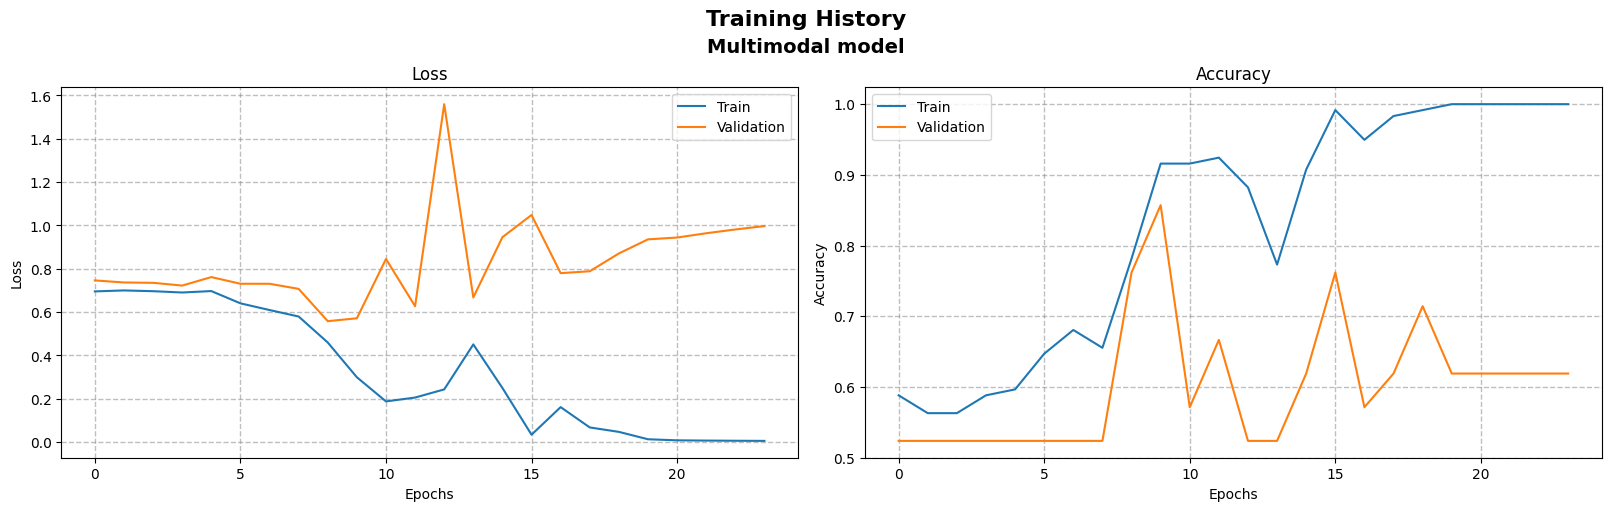

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(16, 5))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

# create 3x1 subfigs
subfig = fig.subfigures(nrows=1, ncols=1)
subfig.suptitle(f'Img model', fontsize=14, fontweight='bold')
axs = subfig.subplots(nrows=1, ncols=2)
for col, ax in enumerate(axs):
    if col == 0:
        ax.grid(color='gray', linestyle='--', linewidth=1, alpha = 0.5)
        ax.plot(history_train_losses, label='Train')
        ax.plot(history_val_losses, label='Validation')
        ax.set_title('Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

    elif col == 1:
        ax.plot(history_train_accuracy, label='Train')
        ax.plot(history_val_accuracy, label='Validation')
        ax.set_title('Accuracy')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(color='gray', linestyle='--', linewidth=1, alpha = 0.5)